# Проект: вариант 1
<br> Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:</br>
<br>
<li> В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета. </li>
<li> Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.</li>
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

# Задание 1

Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc= {'figure.figsize': (15, 10)}, style='whitegrid' )

Причешем наши данные

In [2]:
# Данные с информацией о дате регистрации юзеров
reg_data = pd.read_csv('/home/jupyter-i.tsukanov-7/Analytics_Course/shared/problem1-reg_data.csv', sep = ';')
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [3]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [4]:
# переведем колонку reg_ts в datetime формат + переименуем на более понятное название
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit = 's')
reg_data = reg_data.rename(columns = {'reg_ts' : 'user_register_datetime'})

In [5]:
# Данные с информацией о дате входа в приложение юзеров
auth_data = pd.read_csv('/home/jupyter-i.tsukanov-7/Analytics_Course/shared/problem1-auth_data.csv', sep=';')
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [6]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [7]:
# переведем колонку auth_ts в datetime формат + переименуем на более понятное название
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit = 's')
auth_data = auth_data.rename(columns = {'auth_ts' : 'user_authentication_datetime'})

Объединим данные в один датасет

In [8]:
full_df = reg_data.merge(auth_data, on = 'uid', how = 'outer')
full_df.head()

,user_register_datetime,uid,user_authentication_datetime
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39


In [9]:
full_df.describe()

,uid
count,9.601013e+06
mean,3.347198e+05
std,2.832669e+05
min,1.000000e+00
25%,9.599700e+04
50%,2.579210e+05
75%,5.190250e+05
max,1.110622e+06


In [10]:
len(full_df.index)

9601013

Пишем функцию по подсчету retention:

In [11]:
def retention(df):
    # Меняем формат даты для группировки
    df.user_register_datetime = df.user_register_datetime.dt.date
    df.user_authentication_datetime = df.user_authentication_datetime.dt.date

    # Сделаем колонку с разницей даты - между регистрацией и заходом

    df['difference_in_days'] = (df.user_authentication_datetime - df.user_register_datetime).dt.days

    # Создаем таблицу, подсчитывающую кол-во uid
    # Сразу же сбрасываем индексы
    cohort_data = df.groupby(['user_register_datetime', 'difference_in_days']) \
                            .agg({'uid':'nunique'}).sort_values(by='difference_in_days').reset_index()

    # Для более понятного названия переименовываем столбцы
    cohort_data.rename(columns={'user_register_datetime': 'Cohort', 'difference_in_days': 'Cohort_Period'}, inplace=True)

    # Создаем сводную таблицу 
    retention_cohort = cohort_data.pivot(index='Cohort', columns='Cohort_Period', values='uid')
    
    # Считаем retention
    
    retention = retention_cohort.divide(retention_cohort[1], axis=0).round(3)
    retention = retention.fillna(0)
    
    #Нарисуем хитмап для retention - 14 дней (просто больше нормально не влезет)
    
    retention_map = retention[[i for i in range(1,15)]].tail(15)
    plt.figure(figsize=(20, 15))
    plt.title("Gamers' Retention")
    ax = sns.heatmap(data=retention_map, annot=True, fmt='.0%', cmap='Blues')
    ax.set_yticklabels(retention_map.index)
    fig=ax.get_figure()

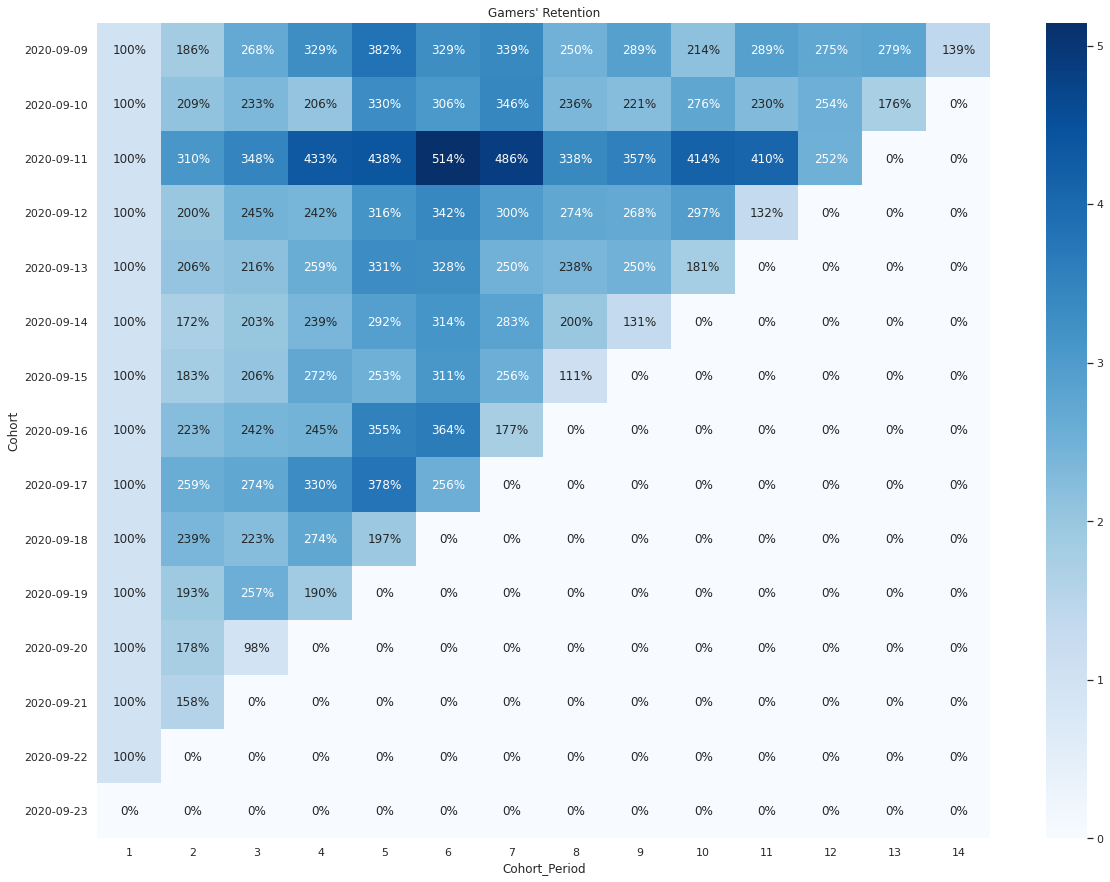

In [12]:
retention(full_df)